# EECE5644-Assignment-4
### Venkata Buddha Work

In [27]:
import copy
import cvxpy as cp
import matplotlib.pyplot as plt # For general plotting
from sys import float_info  # Threshold smallest positive floating value
import matplotlib.colors as mcol
import numpy as np
from numpy import linalg as la
import pandas as pd
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary # Utility to visualize PyTorch network and shapes
from sklearn.model_selection import KFold # Important new include
from scipy.optimize import minimize
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC

np.set_printoptions(suppress=True)
np.random.seed(16)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## FUNCTIONS

In [28]:
def generate_data_from_gmm(N, pdf_params):
    n = pdf_params['m'].shape[1]
    X = np.zeros([N, n])
    labels = np.zeros(N)
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L: #1,2
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        Nl = len(indices) 
        labels[indices] = l * np.ones(Nl) - 1
        X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels, u, thresholds

def generateSamples(N):
    gmm_pdf = {}
    gmm_pdf['m'] = np.array([[0,0],
                             [0,0]])
    gmm_pdf['priors'] = np.array([0.5, 0.5])
    gmm_pdf['C'] = np.array([[[1,0],
                              [0,1]],
                             [[1,0],
                              [0,1]]])
    n,labels,u,thresholds = generate_data_from_gmm(N, gmm_pdf)
    theta = np.random.uniform(low = -np.pi, high = np.pi, size=N)
    x = np.zeros([N, 2])
    rl = np.array([2,4])
    
    L = np.array(range(1, len(gmm_pdf['priors'])+1))
    for l in L:
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        Nl = len(indices)
        if l==1:
            x[indices,0] = rl[l-1]*np.cos(theta[indices]) #class 1 (-1)
            x[indices,1] = rl[l-1]*np.sin(theta[indices])
        elif l==2:
            x[indices,0] = rl[l-1]*np.cos(theta[indices]) #class 2 (+1)
            x[indices,1] = rl[l-1]*np.sin(theta[indices])
    x = x + n
    return x, labels

## ERM classification rule (min prob. of error classifier)

In [29]:
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    C = np.array([0, 1])
    class_cond_likelihoods = np.array([mvn.pdf(X, gmm_params['m'][c], gmm_params['C'][c]) for c in C])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    return np.argmin(risk_mat, axis=0)

In [30]:
def softmax(x):
    # Numerically stable with large exponentials (log-sum-exp trick if you're curious)
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)   

In [31]:
class TwoLayerMLP(nn.Module):
    # Two-layer MLP (not really a perceptron activation function...) network class
    
    def __init__(self, input_dim, hidden_dim, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from input_dim (n) -> hidden_layer_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        # Output layer again fully connected mapping from hidden_layer_dim -> outputs_dim (C)
        self.output_fc = nn.Linear(hidden_dim, C)
        # Log Softmax (faster and better than straight Softmax)
        # dim=1 refers to the dimension along which the softmax operation is computed
        # In this case computing probabilities across dim 1, i.e., along classes at output layer
        self.log_softmax = nn.LogSoftmax(dim=1) 
        
    # Don't call this function directly!! 
    # Simply pass input to model and forward(input) returns output, e.g. model(X)
    def forward(self, X):
        # X = [batch_size, input_dim (n)]
        X = self.input_fc(X)
        # Non-linear activation function, e.g. ReLU (default good choice)
        # Could also choose F.softplus(x) for smooth-ReLU, empirically worse than ReLU
        X = F.relu(X)
        # X = [batch_size, hidden_dim]
        # Connect to last layer and output 'logits'
        X = self.output_fc(X)
        # Squash logits to probabilities that sum up to 1
        y = self.log_softmax(X)
        return y

In [32]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):
    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model

In [33]:
def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        return np.argmax(predicted_labels, 1)

In [34]:
def kFoldMLP(percep, X_train, y_train, C):
    
    #Find certain parameters 
    K = 10
    n_percep = np.max(percep) # P perceptrons ("hyperparameters") to evaluate
    prob_error_train = np.empty((n_percep, K)) # Allocate space for probability error train error array - percep * 10
    mean_prob_err_per_fold = np.empty((n_percep))
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    # Shuffles data before doing the division into folds (not necessary, but a good idea)
     # Number of folds for CV
    kf = KFold(n_splits=K, shuffle=True) 
    
    # STEP 2: Try number of perceptrons between 1-20 for the hidden layer
    for per in percep:
        k = 0
        for train_indices, valid_indices in kf.split(X_train):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_train[train_indices]
            y_train_k = y_train[train_indices]
            X_valid_k = X_train[valid_indices]
            y_valid_k = y_train[valid_indices]
            
            # Train model parameters
            input_dim = X_train_k.shape[1]
            model = TwoLayerMLP(input_dim, per, C)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            X_tensor = torch.FloatTensor(X_train_k)
            y_tensor = torch.LongTensor(y_train_k)
            X_tensor_valid = torch.FloatTensor(X_valid_k) #what we're testing the model on
            y_tensor_valid = torch.LongTensor(y_valid_k)
            model = model_train(model, X_tensor, y_tensor, criterion, optimizer, num_epochs=100) # Trained model 
            Z = model_predict(model, X_tensor_valid) #predictions resulting from the forward pass through the network
            
            #Record Probability Error for Training Data
            N = y_tensor_valid.shape
            conf_mat = confusion_matrix(Z, y_tensor_valid)
            correct_class_samples = np.sum(np.diag(conf_mat))
            prob_error_train[per-1, k] = 1 - (correct_class_samples / N)
            k += 1
        mean_prob_err_per_fold[per-1] = np.mean(prob_error_train[per-1,:])
            
    # STEP 3: Compute the lowest error
    KF_min_err = np.min(mean_prob_err_per_fold)
    num_perc = np.argmin(mean_prob_err_per_fold)
    
    return KF_min_err, num_perc, mean_prob_err_per_fold

In [35]:
def trainData(X_test, y_test, X_train, y_train, per, C):
    
    # Train model parameters
    input_dim = X_train.shape[1]
    model = TwoLayerMLP(input_dim, per, C)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.LongTensor(y_train)
    X_tensor_test = torch.FloatTensor(X_test)
    y_tensor_test = torch.LongTensor(y_test)
    model = model_train(model, X_tensor, y_tensor, criterion, optimizer, num_epochs=100) # Trained model 
    Z = model_predict(model, X_tensor_test) #predictions resulting from the forward pass through the network
            
    #Record Probability Error for Training Data
    N = y_tensor_test.shape
    conf_mat = confusion_matrix(Z, y_tensor_test)
    correct_class_samples = np.sum(np.diag(conf_mat))
    error = 1 - (correct_class_samples / N)
    
    return error

In [36]:
def kFoldSVM(X_train, y_train, box_constraints, gamma):
    
    #Find certain parameters 
    K = 10
    n_box = len(box_constraints) 
    n_gam = len(gamma)
    prob_error_train = np.empty((K)) #use to find best probability error per fold
    gam_box_err = np.empty((n_box*n_gam,3)) #records every gamma, box cons, and error (after each 10-fold)

    kf = KFold(n_splits=K, shuffle=True) 
    
    ct = 0 #keeps track of what iteration
    for C in box_constraints:
        for gam in gamma:
            k = 0 #keeps track of folds
            for train_indices, valid_indices in kf.split(X_train):
                # Extract the training and validation sets from the K-fold split
                X_train_k = X_train[train_indices]
                y_train_k = y_train[train_indices]
                X_valid_k = X_train[valid_indices]
                y_valid_k = y_train[valid_indices]

                # Train model parameters
                rbf_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=gam, C=C))
                rbf_svc.fit(X_train_k, y_train_k)
                y_pred = rbf_svc.predict(X_valid_k)

                #Record Probability Error for Training Data
                N = y_valid_k.shape
                conf_mat = confusion_matrix(y_pred, y_valid_k)
                correct_class_samples = np.sum(np.diag(conf_mat))
                prob_error_train[k] = 1 - (correct_class_samples / N)
                k += 1
            gam_box_err[ct,0] = gam
            gam_box_err[ct,1] = C
            gam_box_err[ct,2] = np.min(prob_error_train)
            ct +=1
    
    return gam_box_err

Generate 1000 independent and identically distributed (iid) samples for training and 10000 iid
samples for testing. All data for class l ∈ {−1,+1} should be generated as follows:
x = rl*[cos(θ); sin(θ)] + n 
where θ ∼ Uniform[−π,π] and n ∼ N(0,σ^2*I). Use r_−1 = 2,r_+1 = 4,σ = 1.

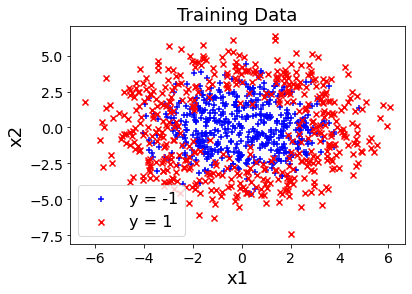

In [40]:
Ntrain = 1000
Ntest = 10000
C = 2 #num of classes

x_train, y_train = generateSamples(Ntrain)
x_test, y_test = generateSamples(Ntest)

fig = plt.figure()
indices_y0 = np.argwhere((y_train[:] == 0))[:, 0]
indices_y1 = np.argwhere((y_train[:] == 1))[:, 0]
plt.scatter(x_train[indices_y0,0],x_train[indices_y0,1], c='b',marker='+', label="y = -1")
plt.scatter(x_train[indices_y1,0],x_train[indices_y1,1], c='r',marker='x',label="y = 1")
plt.plot()
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training Data")
plt.show()

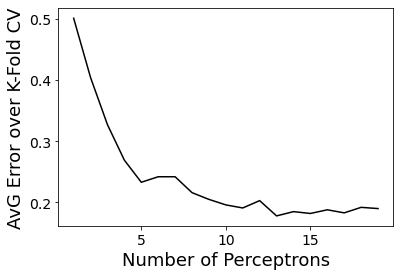

The best perceptrons is  12  which gave an error of  0.178
The best kernel is  0.30000000000000004 , and the best box constraint is  1.5  which gave an error of  0.06000000000000005


In [41]:
#Use the training data with 10-fold cross-validation to determine the best hyperparameters
#MLP - number of perceptrons in the hidden layer
perceptrons = np.arange(1, 20, 1) #array 1-50 in order
MLP_min_err, num_perceptrons, avg_err_percep_arr = kFoldMLP(perceptrons, x_train, y_train, C)
fig = plt.figure()
plt.plot(perceptrons,avg_err_percep_arr, c='k')
plt.xlabel("Number of Perceptrons")
plt.ylabel("AvG Error over K-Fold CV")
plt.show()
print("The best perceptrons is ", num_perceptrons, " which gave an error of ", MLP_min_err)

#SVM - box constraints parameter and Gaussian kernel width
# SVC with Gaussian/RBF kernel
# Pipeline of sequentially applied transforms before producing the final estimation, e.g. Support Vector Classifier
box_constraints = np.arange(1, 5, 0.5)
gamma = np.arange(0.1, 3, 0.2)
gam_box_err = kFoldSVM(x_train, y_train, box_constraints, gamma) 
SVM_min_err = np.min(gam_box_err[:,2])
indices_min_err = np.argmin(gam_box_err[:,2])
ideal_gamma = gam_box_err[indices_min_err,0]
ideal_box = gam_box_err[indices_min_err,1]
#plotting best gamma per box constraint
print("The best kernel is ", ideal_gamma, ", and the best box constraint is ", ideal_box, " which gave an error of ", SVM_min_err)

MLP: Probability of error on the test dataset is  0.17490000000000006
SVM: Probability of error on the test dataset is  0.16649999999999998


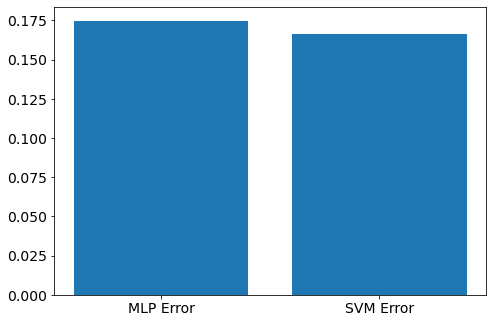

In [39]:
#Once these hyperparameters are set, train your final SVM and MLP classifier using the entire training data set
#Apply your trained SVM and MLP classifiers to the test data set and estimate the probability of error from this data set
#MLP
input_dim = x_train.shape[1]
model = TwoLayerMLP(input_dim, num_perceptrons, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
x_tensor_train = torch.FloatTensor(x_train)
y_tensor_train = torch.LongTensor(y_train)
x_tensor_test = torch.FloatTensor(x_test) #what we're testing the model on
y_tensor_test = torch.LongTensor(y_test)
model = model_train(model, x_tensor_train, y_tensor_train, criterion, optimizer, num_epochs=100) # Trained model 
Z = model_predict(model, x_tensor_test) #predictions resulting from the forward pass through the network
conf_mat = confusion_matrix(Z, y_tensor_test)
correct_class_samples = np.sum(np.diag(conf_mat))
prob_err_MLP = 1 - (correct_class_samples / Ntest)
print("MLP: Probability of error on the test dataset is ", prob_err_MLP)

#SVM
rbf_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=ideal_gamma, C=ideal_box))
rbf_svc.fit(x_train, y_train)
y_pred = rbf_svc.predict(x_test)
conf_mat = confusion_matrix(y_pred, y_test)
correct_class_samples = np.sum(np.diag(conf_mat))
prob_err_SVM = 1 - (correct_class_samples / Ntest)
print("SVM: Probability of error on the test dataset is ", prob_err_SVM)

#plotting errors
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
names = ['MLP Error', 'SVM Error']
errors = [prob_err_MLP,prob_err_SVM]
ax.bar(names,errors)
plt.show()